# Regularización de modelos de regresión lineal

### **¿Los modelos lineales sobreajustan?**
- Los modelos lineales son más simples que otras alternativas
    - -> Tienden a sobreajustar menos que las alternativas
- Incluso a menudo subajustan cuando:
    - n_features es pequeño (por ejemplo, menos de 10 características)
    - El problema no es linealmente separable

Pero...

### **¡Los modelos lineales pueden sobreajustar!**

Posibles causas:

- n_samples << n_featunes
- muchas características no informativas

Ejemplo para regresión lineal:

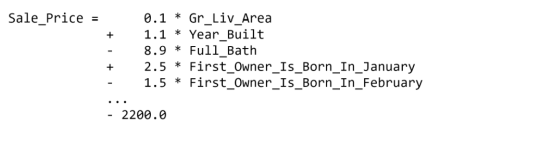

## La Regularización puede reducir el sobreajuste

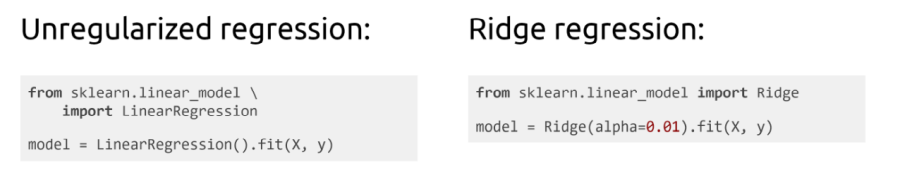

La regresión de Ridge lleva los coeficientes hacia 0.
- Alpha grande -> Más regularización

Recomendación: ¡Siempre usar Ridge con un alpha cuidadosamente ajustado!

### Regularización en un ejemplo simple

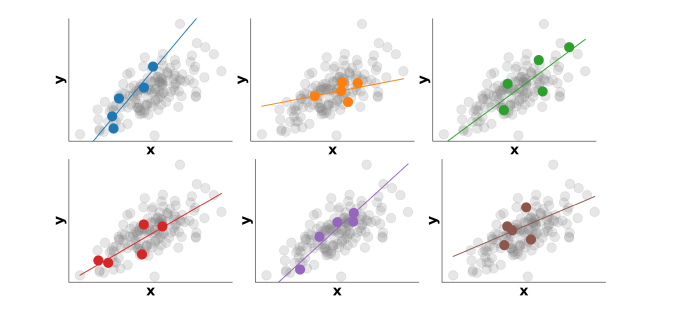

**Compensación Sesgo-Varianza en regresión Ridge**

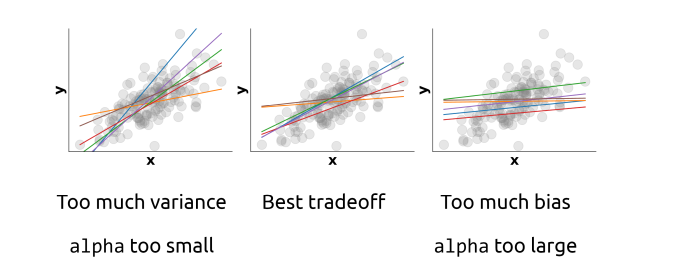

### Ajuste automático para regularización

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
param_grid = {
    "alpha": [0.001, 0.1, 1, 10, 1000],
}
model = GridSearchCV(Ridge(), param_grid)
model.fit(X, y)
print(model.best_parameters_)

In [ ]:
from sklearn.linear_model import RidgeCV
model = RidgeCV(
    alphas=[0.001, 0.1, 1, 10, 1000]
)
model.fit(X, y)
print(model.alpha_)

**¡Casi tan rápido como ajustar un modelo de una sola cresta!**

## Regularización en regresión logística

LogisticRegression(C=1):
- ¡Está regularizada por defecto!
- Valor de C alto -> regularización más débil.

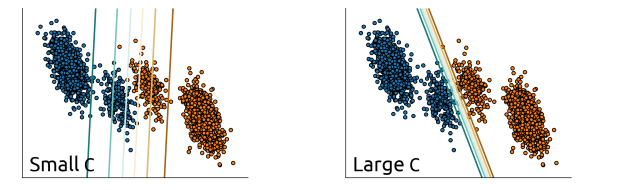

## Conclusiones

- Puede sobreajustar cuándo:
    - n_samples es demasiado pequeño y n_features es grande
    - en particular con características no informativas
- Regularización para la regresión:
    - regresión lineal -> regresión de Ridge
    - parámetro alpha grande -> regularización fuerte
- Regularización para la clasificación:
    - ¡Regresión logística regularizada por defecto!
    - parámetro C pequeño -> regularización fuerte

# Efecto de la regularización

In [ ]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(as_frame=True, return_X_y=True)
target *= 100  # rescala el objetivo en k$
data.head()

In [ ]:

# usar el transformador PolynomialFeatures para crear características adicionales
# Codificar interacciones no lineales entre características.

from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

linear_regression = make_pipeline(PolynomialFeatures(degree=2),
                                  LinearRegression())
cv_results = cross_validate(linear_regression, data, target,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)

In [ ]:
train_error = -cv_results["train_score"]
print(f"Error cuadrático medio del modelo de regresión lineal en el set de entrenamiento:\n"
      f"{train_error.mean():.3f} ± {train_error.std():.3f}")

In [ ]:
test_error = -cv_results["test_score"]
print(f"Error cuadrático medio del modelo de regresión lineal en el set de pruebas:\n"
      f"{test_error.mean():.3f} ± {test_error.std():.3f}")

**⚠️ La puntuación en el set de entrenamiento es mucho mejor.**
- Esta brecha de rendimiento de generalización entre entrenamiento y prueba es una indicación de que nuestro modelo sobreajustó nuestro conjunto set entrenamiento.

In [ ]:
# Dado que usamos un PolynomialFeatures para aumentar los datos, 
# crearemos nombres de características representativas de la combinación de características.

model_first_fold = cv_results["estimator"][0]

In [ ]:
# Ahora podemos acceder a los PolynomialFeatures ajustados para generar los nombres de características

feature_names = model_first_fold[0].get_feature_names_out(
    input_features=data.columns)
feature_names

In [ ]:
# Finalmente, podemos crear un DataFrame que contenga toda la información.

import pandas as pd

coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_linear_regression = pd.DataFrame(coefs, columns=feature_names)

In [ ]:
# Ahora, usemos un box plot para ver las variaciones de coeficientes.

import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
weights_linear_regression.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Coeficientes de regresión lineal")

In [ ]:
# Podemos forzar al modelo de regresión lineal a considerar todas las características de una manera más homogénea.

from sklearn.linear_model import Ridge

ridge = make_pipeline(PolynomialFeatures(degree=2),
                      Ridge(alpha=100))
cv_results = cross_validate(ridge, data, target,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)

*La celda del código anterior generará un advertencias porque las características incluían valores extremadamente grandes y extremadamente pequeños, lo que está causando problemas numéricos al entrenar el modelo predictivo.*

In [ ]:
# Podemos explorar el tren y las puntuaciones de prueba de este modelo.

train_error = -cv_results["train_score"]
print(f"Error cuadrático medio del modelo de regresión lineal en el conjunto de entrenamiento:\n"
      f"{train_error.mean():.3f} ± {train_error.std():.3f}")

In [ ]:
test_error = -cv_results["test_score"]
print(f"Error cuadrático medio del modelo de regresión lineal en el conjunto de pruebas:\n"
      f"{test_error.mean():.3f} ± {test_error.std():.3f}")

> Vemos que los puntajes de entrenamiento y pruebas están mucho más cerca, lo que indica que nuestro modelo es menos sobreajustado.

In [ ]:
# Podemos comparar los valores de los pesos de Ridge con los de la regresión lineal no regularizada.

coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge = pd.DataFrame(coefs, columns=feature_names)

In [ ]:
weights_ridge.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Pesos Ridge")

Al comparar la magnitud de los pesos en este gráfico en comparación con el anterior, vemos que un modelo ridge aplicará todos los pesos para tener una magnitud similar, mientras que la magnitud general de los pesos se reduce hacia cero con respecto al modelo de regresión lineal.

# Escalado de características y regularización

- Por un lado, los **pesos** definen el enlace entre los valores de la característica y el objetivo predecido. 
- Por otro lado, la **regularización** añade restricciones a los pesos del modelo a través del parámetro alpha. 
- Por lo tanto, el efecto que el **reescalado de característica** tiene en los pesos finales también interactúa con la regularización.

In [ ]:
# Agregaremos un StandardScaler en el pipeline 
# Este escalador se colocará justo antes del regresor.

from sklearn.preprocessing import StandardScaler

ridge = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(),
                      Ridge(alpha=0.5))
cv_results = cross_validate(ridge, data, target,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)

In [ ]:
train_error = -cv_results["train_score"]
print(f"Error cuadrático medio del modelo de regresión lineal en el conjunto de entrenamiento:\n"
      f"{train_error.mean():.3f} ± {train_error.std():.3f}")

In [ ]:
test_error = -cv_results["test_score"]
print(f"Error cuadrático medio del modelo de regresión lineal en el conjunto de pruebas:\n"
      f"{test_error.mean():.3f} ± {test_error.std():.3f}")

- Observamos que la escala de datos tiene un **impacto positivo** en la puntuación de la prueba y que este está más cerca del puntaje de entrenamiento.
- Significa que nuestro modelo está menos sobreajustado y que nos estamos acercando al mejor punto de generalización.

In [ ]:
# Veamos un aspecto adicional a los diferentes pesos.

coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge = pd.DataFrame(coefs, columns=feature_names)

weights_ridge.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Pesos Ridge con escala de datos")

> **Comparando con los plots anteriores, vemos que ahora todas las magnitudes de peso están más cerca y que todas las características contribuyen más.**


In [ ]:
# En el ejemplo anterior, fijamos alpha = 0.5.
# Ahora verificaremos el impacto del valor del alfa aumentando su valor.

ridge = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(),
                      Ridge(alpha=1_000_000))
cv_results = cross_validate(ridge, data, target,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)

coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge = pd.DataFrame(coefs, columns=feature_names)

weights_ridge.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Pesos Ridge con escala de datos y alpha grande")

**Observando específicamente a los valores de los pesos, observamos que aumentar el valor del alpha disminuirá los valores de peso.**
- Un valor negativo de alfa en realidad mejoraría pesos grandes y promovería el sobreajuste.

# Ajuste fino del parámetro de regularización
- Como hemos mencionado, **el parámetro de regularización debe ajustarse en cada conjunto de datos**.
- El parámetro predeterminado no conducirá al modelo óptimo.
- Por lo tanto, necesitamos ajustar (sintonizar) el parámetro alfa.

Por lo tanto, debemos incluir la búsqueda del hiperparámetro alpha en la validación cruzada: podríamos usar una *búsqueda de cuadrícula*.
- No obstante, algunos predictores en Scikit-Learn están disponibles con una *búsqueda integrada de hiperparámetros* más eficiente.
- **El nombre de Estos predictores terminan con CV**.
    - En el caso de Ridge, Scikit-Learn proporciona un regresor **RidgeCV**.

- Podemos usar este predictor como último paso del pipeline.
- Incluyendo una validación cruzada permitirá hacer una **validación cruzada anidada**: 
    - la **validación cruzada interna** buscará el mejor alfa
    - mientras que la **validación cruzada externa** dará una estimación del puntaje de prueba.

In [ ]:
import numpy as np
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-2, 0, num=20)
ridge = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(),
                      RidgeCV(alphas=alphas, store_cv_values=True))

In [ ]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, random_state=1)
cv_results = cross_validate(ridge, data, target,
                            cv=cv, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True, n_jobs=2)

In [ ]:
train_error = -cv_results["train_score"]
print(f"Mean squared error of linear regression model on the train set:\n"
      f"{train_error.mean():.3f} ± {train_error.std():.3f}")

In [ ]:
test_error = -cv_results["test_score"]
print(f"Mean squared error of linear regression model on the test set:\n"
      f"{test_error.mean():.3f} ± {test_error.std():.3f}")

Al ajustar el regresor ridge, también almacenamos el error encontrado durante la validación cruzada (configurando el parámetro `store_cv_values ​​= True`).
- Trazaremos el error cuadrático medio para la fuerza de regularización de los diferentes alpha que probamos.

In [ ]:
mse_alphas = [est[-1].cv_values_.mean(axis=0)
              for est in cv_results["estimator"]]
cv_alphas = pd.DataFrame(mse_alphas, columns=alphas)
cv_alphas

In [ ]:
cv_alphas.mean(axis=0).plot(marker="+")
plt.ylabel("Error cuadrático medio \n (más bajo mejor)")
plt.xlabel("alpha")
_ = plt.title("Error obtenido por validación cruzada")

In [ ]:
best_alphas = [est[-1].alpha_ for est in cv_results["estimator"]]
best_alphas

- La fuerza de regularización óptima no es necesariamente la misma en todas las iteraciones de validación cruzada. 

- Pero dado que esperamos que cada remuestreo de validación cruzada se deriva de la misma distribución de datos, es práctica común **usar el valor promedio del mejor alpha** encontrado en diferentes pliegues de validación cruzada como nuestra estimación final para el ajuste de alpha.

In [ ]:
print(f"El alpha óptimo medio que conduce al mejor rendimiento de generalización es:\n"
      f"{np.mean(best_alphas):.2f} ± {np.std(best_alphas):.2f}")